# Performing an Error Mitigation Workflow with Program Sets on Amazon Braket (Advanced)

This notebook builds on topics present in the error mitigation workflow seen using mitiq, but instead focuses on a QHP-based (Rigetti) workflow. As such, it requires substantial customization beyond what is commonly available. 
>[!WARNING]
>Executing this notebook with devices will charge your AWS account! Please keep this in mind and verify with the previous notebook tracker. 

### Overview of Device Orientied Error Mitigated Workflow

We forgoe using mitiq, namely because most of the features which do helpful things like modify circuits are not specific enough for our purposes, and are not currently implemented or supported in mitiq. 

However, we can use the general workflow, i.e. ZNE + twirl + REM. This is common enough in the literature. 

To submit things a device, we still need a few adjustments to our workflow. In particular we have a few additions to optiimze performance and minimize cost: 

- Update shot allocation:
    - For observables 
    - For the exponential regression 
- Perform compilation to native gates and an optimized layout 
- Twirl with native gates (ISwap for Rigetti)
- Utilize a scalable REM procedure (i.e. we use a sparse REM)
- Tighten overheads

We begin in a largely similar way, although will utilize the `qiskit_braket_provider` to help convert some of our circuits. 

In [2]:
import os
import sys

import numpy as np

from braket.circuits import Circuit

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))) # parent  

import json
from collections import defaultdict
from warnings import filterwarnings

import matplotlib.cm as cm
from matplotlib_venn import venn3
# need these for later
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_braket_provider import BraketProvider, to_braket
from tools.circuit_tools import (
    convert_paulis,
    fidelity_estimation,
    find_linear_chain,
    multiply_gate,
    restricted_circuit_layout,
    strip_verbatim,
)
from tools.mitigation_tools import (
    SparseReadoutMitigation,
    apply_readout_twirl,
    generate_bit_mask,
    get_twirled_readout_dist,
    twirl_iswap,
)
from tools.observable_tools import pauli_grouping
from tools.program_set_tools import ANKAA_CONVERSION, run_with_program_sets
from tools.stat_tools import jackknife_bias_corrected, perform_regression

from braket.aws import AwsDevice
from braket.devices import Devices, LocalSimulator
from braket.emulation.local_emulator import LocalEmulator

filterwarnings("ignore",category=UserWarning, module="qiskit_braket_provider")

np.set_printoptions(precision=3, linewidth=500, suppress=True)

with open("ankaa_properties_251222.json","r") as fp:
    props_em = json.load(fp)

emulator = LocalEmulator.from_json(props_em)
nm = emulator._noise_model 
qd = LocalSimulator("braket_dm",noise_model= emulator._noise_model)
print('loaded ankaa-3 emulator ')

# emulator = LocalSimulator()

# ankaa = AwsDevice(Devices.Rigetti.Ankaa3)
# props = ankaa.properties.standardized
# backend = BraketProvider().get_backend('Ankaa-3')
# print('loaded Ankaa-3 device and backend')


loaded ankaa-3 emulator 


Now we define our problem Hamiltonian, here a simple Ising Hamiltonian. For simplicity, we use a simple string representation of the Pauli operators, and a greedy color-based grouping scheme using networkx. 

Unlike the previous approach, here we will push our system size, using 10 qubits for the emulator, but up to 30 on the device. 

In [3]:
def ising_hamiltonian(
        interaction : float, 
        transverse_field : float, 
        num_qubits : int):
    hamiltonian = []
    n = num_qubits
    for i in range(num_qubits):
        hamiltonian.append(
            (transverse_field,i*"I"+"X"+(n-i-1)*"I")
            )
        if i>0:
            hamiltonian.append(
                (interaction, (i-1)*"I"+"ZZ"+(n-i-1)*"I"))
    return hamiltonian

interaction = 0.1
transverse_field = -0.02
num_qubits = 5

ham = ising_hamiltonian(interaction, transverse_field, num_qubits = num_qubits)

bases, pauli_terms = pauli_grouping(ham)
# print(bases)
print(f'number of distinct measurement bases: {len(bases)}') 
print(bases)
print(pauli_terms)


number of distinct measurement bases: 2
['XXXXX', 'ZZZZZ']
[[(-0.02, 'IXIII'), (-0.02, 'IIXII'), (-0.02, 'IIIXI'), (-0.02, 'XIIII'), (-0.02, 'IIIIX')], [(0.1, 'ZZIII'), (0.1, 'IZZII'), (0.1, 'IIZZI'), (0.1, 'IIIZZ')]]


### Step 0.0 - Shot allocation

Now, we can further consider the L1 norm of the total coefficients. That is, let $\alpha$ denote a base, and $c_i^\alpha$ a term $i$ within the base, we can then calculate the $l_1$ norm for each base:

In [4]:
norms = np.array([sum([abs(p[0]) for p in items]) for items in pauli_terms])
print('Norms per measurement basis: ',norms)

interaction = interaction / np.sum(norms)
transverse_field = transverse_field / np.sum(norms) 

ham = ising_hamiltonian(interaction, transverse_field,num_qubits = num_qubits)

bases, pauli_terms = pauli_grouping(ham)
# print(bases)
print(f'number of distinct measurement bases: {len(bases)}') 
print(bases)
print(pauli_terms)
norms = np.array([sum([abs(p[0]) for p in items]) for items in pauli_terms])
print('Renormalized norms: ',norms)

Norms per measurement basis:  [0.1 0.4]
number of distinct measurement bases: 2
['XXXXX', 'ZZZZZ']
[[(-0.04, 'IXIII'), (-0.04, 'IIXII'), (-0.04, 'IIIXI'), (-0.04, 'XIIII'), (-0.04, 'IIIIX')], [(0.2, 'ZZIII'), (0.2, 'IZZII'), (0.2, 'IIZZI'), (0.2, 'IIIZZ')]]
Renormalized norms:  [0.2 0.8]


We then use code from a previous notebook on ProgramSets: 

In [5]:
def allocate_by_weight(
    target_weights: list[int | float], 
    total_allocation: int, 
    min_allocation: int = 1
) -> list[int]:
    """
    Allocate items by weight with minimum allocation constraints.
    
    Args:
        target_weights: List of target weights
        total_allocation: Total number of items to allocate
        min_allocation: Minimum allocation per bin
        
    Returns:
        List of allocated counts per bin, approximating the provided target weight.
    """
    size = len(target_weights)
    
    assert (min_allocation*size <= total_allocation), \
         f"Can't allocate {total_allocation} items across {size} bins with at least {min_allocation} items per bin"

    allocation = [min_allocation] * size # Secure the required minimum allocation first
    for i in range(total_allocation - min_allocation*size):
        idx = max(range(size), key = lambda j: abs(target_weights[j]) / (max(allocation[j],1)))
        allocation[idx] += 1

    return allocation

Text(0, 0.5, 'Distance from target distribution')

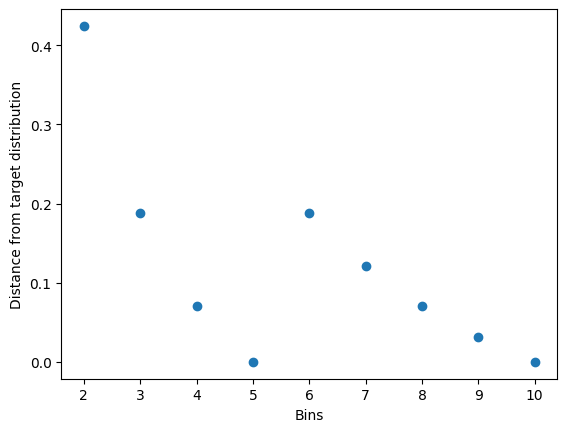

In [6]:
residuals = []
for total_terms in range(2,11):
    res = np.array(allocate_by_weight(target_weights= norms / np.sum(norms), 
                             total_allocation=total_terms, min_allocation=1))
    residuals.append(np.linalg.norm(norms / np.sum(norms) - res / np.sum(res)))
plt.scatter(range(2,11), residuals)
plt.xlabel("Bins")
plt.ylabel("Distance from target distribution")
    

6 bins is basically the exact solution, and this should help to reduce our variance. Generally, our variance can be calculated as:

$ {\rm Var}[O] = \sum \frac{|c_i|^2}{M_j}$ 
where $c_i$ is the coefficient and $M_j$ is the number of shots. Let $p$ denote the fraction of circuits allocated for the $X_i$ observables, then we have that $M = M_z + M_x = (1-p_z) M + p M$. The variance expression is then:

$ {\rm Var}[O] \approx N_q \frac{|U|^2}{p M} + (N_q-1) \frac{|V|^2}{(1-p)M } = \frac{N_q}{M}(\frac{|U|^2}{p} + \frac{N_q -1}{N_q}\frac{|V|^2}{(1-p)})$ 

Better shot allocation strategies usually take preliminary estimations of the observable value into consideration as well, though here we average over all possible states. 

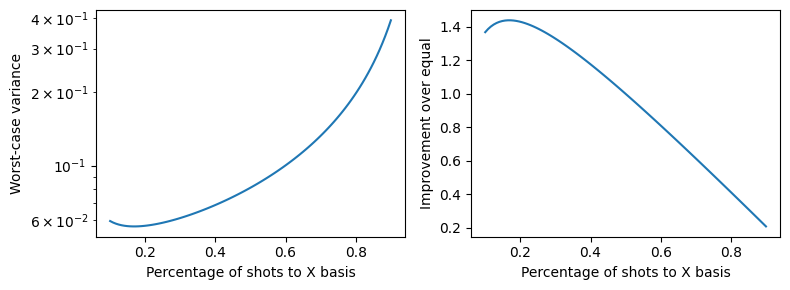

In [7]:
def worst_case(p, num_qubits):
    return (transverse_field)**2/p + (interaction)**2 * (num_qubits - 1)/num_qubits / (1-p)

xs = np.linspace(0.1, 0.9, 100)
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(xs,worst_case(xs, 40),)
ax[0].set_xlabel("Percentage of shots to X basis")
ax[1].set_xlabel("Percentage of shots to X basis")
ax[0].set_ylabel("Worst-case variance")
ax[1].set_ylabel("Improvement over equal")
ax[0].set_yscale('log')
ax[1].plot(xs, worst_case(0.5, 40) /  worst_case(xs, 40) ,label="Improvement")
plt.tight_layout()
plt.show()

In [8]:
multiplicity = [1,5]
multiplicity = [1,4]

bases_expanded = [bases[0]] * multiplicity[0] + [bases[1]] * multiplicity[1]
paulis_expanded = []
for reps, items in zip(multiplicity, pauli_terms):
    paulis_expanded.extend([(c/reps,p) for c,p in items] for _ in range(reps))

print(paulis_expanded[0])

[(-0.04, 'IXIII'), (-0.04, 'IIXII'), (-0.04, 'IIIXI'), (-0.04, 'XIIII'), (-0.04, 'IIIIX')]


### Step 0.1 - Preparing a native circuit

Here, we use a simple layer / brick circuit, simplifying from previous work. The main goal of this experiment will be to mitigate the zero state. That is, we have a circuit that we know is essentially the identity, and we are seeing to what extent we can reproduce it. 

In [9]:
def test_circuit(
        num_qubits : int):
    circ = Circuit()
    for i in range(num_qubits):
        circ.rx(i,np.pi)
    for i in range(0,num_qubits-1,2):
        circ.iswap(i,i+1)
    for i in range(num_qubits):
        circ.rz(i,0.0001,)
    for i in range(1,num_qubits-1,2):
        circ.iswap(i,i+1)
    for i in range(num_qubits):
        circ.rz(i,0.0001,)
    for i in range(0,num_qubits-1,2):
        circ.iswap(i,i+1)
    for i in range(num_qubits):
        circ.rz(i,0.0001,)
    for i in range(1,num_qubits-1,2):
        circ.iswap(i,i+1)
    return circ

ansatz_v0 = test_circuit(num_qubits=num_qubits)
print(ansatz_v0)

T  : │     0      │     1      │     2      │     3      │     4      │     5      │     6      │    7    │
      ┌──────────┐  ┌───────┐   ┌──────────┐ ┌──────────┐               ┌───────┐   ┌──────────┐           
q0 : ─┤ Rx(3.14) ├──┤ ISWAP ├───┤ Rz(0.00) ├─┤ Rz(0.00) ├───────────────┤ ISWAP ├───┤ Rz(0.00) ├───────────
      └──────────┘  └───┬───┘   └──────────┘ └──────────┘               └───┬───┘   └──────────┘           
      ┌──────────┐  ┌───┴───┐   ┌──────────┐  ┌───────┐   ┌──────────┐  ┌───┴───┐   ┌──────────┐ ┌───────┐ 
q1 : ─┤ Rx(3.14) ├──┤ ISWAP ├───┤ Rz(0.00) ├──┤ ISWAP ├───┤ Rz(0.00) ├──┤ ISWAP ├───┤ Rz(0.00) ├─┤ ISWAP ├─
      └──────────┘  └───────┘   └──────────┘  └───┬───┘   └──────────┘  └───────┘   └──────────┘ └───┬───┘ 
      ┌──────────┐  ┌───────┐   ┌──────────┐  ┌───┴───┐   ┌──────────┐  ┌───────┐   ┌──────────┐ ┌───┴───┐ 
q2 : ─┤ Rx(3.14) ├──┤ ISWAP ├───┤ Rz(0.00) ├──┤ ISWAP ├───┤ Rz(0.00) ├──┤ ISWAP ├───┤ Rz(0.00) ├─┤ ISWAP ├─
      └──────────┘  └───┬───

Now, we will somewhat modify our transpilation procedure, using some prebuilt functionality in `tools/circuit_tools.py`. First, we will explicitly remove "bad" connections, i.e. gates with a infidelity above a certain threshold. These are penalized by both the Qiskit transpiler and the Braket compiler, but we want to explicitly remove these. 

In [10]:
ansatz_v1 = restricted_circuit_layout(ansatz_v0, ankaa)
print(ansatz_v1)

chain = find_linear_chain(ansatz_v1)


NameError: name 'ankaa' is not defined

We can visualize this below: 

In [ ]:

ankaa_grid = [
    [0,7,14,21,28,35,None,49,56,63,70,77],
    [1,8,15,22,29,36,43,50,57,64,71,78],
    [2,9,16,23,30,37,44,51,58,65,72,79],
    [3,10,17,24,31,38,45,52,59,66,73,80],
    [4,11,18,25,32,39,46,53,60,67,74,81],
    [5,12,19,26,33,40,47,54,61,68,75,82],
    [6,13,20,27,34,41,None,55,62,69,76,83]
]

ankaa_pos = {q:(j,i) for i,row in enumerate(ankaa_grid) for j, q in enumerate(row)}
ankaa_pos_under = {q:(j+0.05,i+0.05) for i,row in enumerate(ankaa_grid) for j, q in enumerate(row)}


props_std = ankaa.properties.standardized.dict()
graph_nodes, graph_edges =list(ankaa.topology_graph.nodes()), list(ankaa.topology_graph.edges())

node_vals = [1 - props_std['oneQubitProperties'][str(node)]['oneQubitFidelity'][0]['fidelity'] for node in graph_nodes]

edge_vals = []
for edge in graph_edges:
    if edge[0] > edge[1]:
        edge = (edge[1], edge[0])
    edge_key = f"{edge[0]}-{edge[1]}"
    fidelity = 1 - props_std['twoQubitProperties'][edge_key]['twoQubitGateFidelity'][0]['fidelity']
    edge_vals.append(fidelity)

fig, ax = plt.subplots(figsize=(14,7))
nx.draw(ankaa.topology_graph, 
        ankaa_pos, 
        node_color=node_vals, 
        edge_color=edge_vals, 
        cmap=cm.coolwarm, 
        edge_cmap=cm.coolwarm, 
        with_labels=True,
        font_color = 'w',
        ax=ax)

traj = [int(k) for k in chain]
traj_x = [ankaa_pos[p][0]-0.15 for p in traj]
traj_y = [ankaa_pos[p][1]-0.15  for p in traj]
plt.plot(traj_x, traj_y, 'g', marker='x' , linewidth=2.5, linestyle='--', label='Layout')
plt.legend()
plt.axis('equal')

plt.tight_layout()

plt.show()


### Step 0.2 - Estimating REM Overhead

Based on our qubit layout, we can evaluate what we expect our 2-qubit REM overhead to be:

In [ ]:
readout_errors = []
for qubit, vals in props.oneQubitProperties.items():
    if int(qubit) not in ansatz_v1.qubits:
        continue
    for item in vals.oneQubitFidelity:
        temp = item.dict()
        if temp['fidelityType']['name'] == "READOUT":
            readout_errors.append(1-temp['fidelity'])

ro_sorted = sorted(readout_errors,reverse=True)
print(ro_sorted)

Assuming we only need two-local qubits, then our result is at worst: 

In [ ]:
gamma = (1/(1-ro_sorted[0])/(1-ro_sorted[1]))**2
print(f'Effective gamma: {gamma}')
print(f'Median gamma: {(1/(1-np.median(ro_sorted)))**4}')

### Step 0.3 - Modeling Extrapolation Errors 

Finally, we perform a very coarse estimate of the extrapolation. We will look at the decay probability of an observable based on the number of two-qubit gates it touches through a lightcone depiction. 

From that, we will see how we expect our variance to increase based on our exponential regression. 

In [ ]:
predicted_fidelity, ins = fidelity_estimation(ansatz_v1, ankaa, "ISwap")
print(f"Predicted active volume fidelity: {predicted_fidelity}")
print(f'Naive percent of ISwaps in the light cone: {ins[0]}/{ins[1]}')


Recalling that for exponential regression, our weights are proportional to the variance 

Naively, we should have that $w_i \propto \frac{1}{\sigma^2} \approx y_i^2 $. This indicates that the variance  $\sigma^2 \propto \frac{1}{y_i^2}$. Practically these are weighted as $\frac{1}{|y_i|}$. 

Given that we have $y_0= 0.78$, we can choose 

In [ ]:
print('predicted fidelities: ')

exps = [1, 2, 4]
var_increase = [predicted_fidelity**2/predicted_fidelity**(2*n) for n in exps]
exp_fid = [predicted_fidelity**(n) for n in exps]
print('expected increase in variance: ')
print(var_increase)
print('expected fidelities')
print(exp_fid)

In [ ]:
scale_factors  = exps
scale_factor_multiplicity = [1,1,2] # set manually
scale_factors_expanded = [s for s, m in zip(scale_factors, scale_factor_multiplicity) for _ in range(m)]
print(f'expanded scale factors: {scale_factors_expanded}')

Thus, we should increase the variance by factors of 1, 2, and 3, to try and account for this increase in variance. 

### Step 0.4 - Set Cost and Resources

Here we define our parameters for our system and subsequent error mitigation. We being with the norm of the Hamiltonian, which here we have normalized to unity. Generally this will increase our variance quadratically. The estimated number of circuits will be naively $N_{ZNE} * N_{para} * N_{twirls} * N_{bases} + N_{REM}$. Explicitly, this is `len(scale_factors) * num_twirls * len(parameters) * len(bases) + rem_twirls`. 

`shot_per_base` here refers to each function evaluation, and naively is distributed according to each observable basis. Overhead is actually that, the multiplicative factor that we will increase by. It can match the REM overhead or potentially exceed it, though there are limits to which we trust the reliability of it.  

In [ ]:
from math import ceil 

precision = 1/np.sqrt(1024)
print(f'Precision: {precision}')
L = np.sum(norms) # set to 1
print(f'Normalization (should be unity): {L}')
assert abs(L-1)<1e-8
shots_per_obs = ceil(1/precision**2)
print('Total shots per observable: {}'.format(shots_per_obs))


To determine our shots, we deal with a number of factors. Roughly speaking, our overhead is the factor above our base precision, or shots per observable. For our mitigation and REM learning, it is the REM overhead times an arbitrary overhead factor.

Given that our observable is split into a product of bases and twirls, this defines our bases number of executables. For instance, with 25 twirls and 6 bases, and 1 `shot_per_executable`, we will still have 150 shots. If our precision requires 400, we need 3 `shots_per_executable` to reach our target precision, i.e. 450 shots. If our overhead was 2, then we would need at least 800 shots total, which is 6 `shots_per_executable` (900 total). 

In [ ]:
from math import ceil

n_bases = len(bases_expanded)
rem_overhead = gamma # let's infer based on reported gamma 
overhead = 1
rem_twirls = 100
num_twirls = 16

exec_per_ev = n_bases * num_twirls
parameters = [{"alp":0.0, "bet":0.0}, {"alp":np.pi, "bet":0.0}][:1]
shots_per_ev =  ceil(shots_per_obs *rem_overhead * overhead / exec_per_ev) * exec_per_ev
mitigation_shots = shots_per_ev * len(scale_factors_expanded) * len(parameters)
shots_per_exec = shots_per_ev // exec_per_ev

print('   --- MITIGATION --- ')
print(f'** given {n_bases} bases and {num_twirls} twirls, we have {exec_per_ev} executables')
print(f'** given an overhead of {overhead:.2f}*{rem_overhead:.2f}={overhead*rem_overhead:.2f}')
print(f'**   and an expected precision of {precision} with {shots_per_obs} shots,')
print(f'**   the number of shots we need for <O> is {shots_per_ev}, i.e. {shots_per_exec} shots per executable')
print(f'** we also expect {len(scale_factors_expanded)*len(parameters)} expectations, yielding a total shots of: {mitigation_shots}')
mitigation_circuits = len(scale_factors_expanded) * num_twirls * len(parameters) * n_bases 
readout_circuits = rem_twirls
print(f'**   this is possible in {mitigation_circuits} circuits \n')

shots_per_ro = ceil(shots_per_ev * rem_overhead / readout_circuits ) 
readout_shots = shots_per_ro * rem_twirls

print('  --- READOUT  --- ')
print(f'** given {rem_twirls} twirls == circuits, and {shots_per_ev} shots per expectation')
print(f'**   we have {shots_per_ro} shots per ro, i.e. {readout_shots} shots total')


print('\n  --- STATISTICS ---')
print(f'** total number of shots: {readout_shots + mitigation_shots}')
print(f"** total number of circuits: {readout_circuits + mitigation_circuits}")
print(f'** shot overhead: {(readout_shots + mitigation_shots)/shots_per_obs:.2f}x')

print('\n  --- COST --- ')
num_ps= ceil(mitigation_circuits / 100) + ceil(readout_circuits) / 100
print(f'** task cost: ${0.3 * num_ps:0.2f}, reduced from ${(mitigation_circuits + readout_circuits)*0.3}')
print(f'** shots cost: ${(readout_shots + mitigation_shots)*0.0009:.2f}, ro/mit:${0.0009*readout_shots:.2f}/${mitigation_shots*0.0009 :.2f}')


### Step 0.5 - Generating Circuits

In [ ]:
folded_circuits = [multiply_gate(ansatz_v1, 'ISwap',scale) for scale in scale_factors_expanded]
circuits = np.array([twirl_iswap(c, num_twirls) for c in folded_circuits], dtype=object)
circuits, twirls =  apply_readout_twirl(circuits)

circuits = np.vectorize(convert_paulis)(circuits)
circuits = np.vectorize(strip_verbatim)(circuits)
print('circuits shape: ',circuits.shape)
print('twirls shape: ', twirls.shape)
assert circuits.shape == twirls.shape
# output is (ZNE, twirls)

def count_iswap(circ : Circuit):
    count = 0
    for instruction in circ.instructions:
        if instruction.operator.name == "ISwap":
            count += 1
    return count

for f in folded_circuits:
    print(count_iswap(f), f'ISwap gates')

In [ ]:
bit_masks = generate_bit_mask(twirls, bases_expanded)


### Error Mitigation Workflow

#### Step 1 - Readout Calibration

`get_twirled_readout_dist` will perform the REM technique described previously, and return the bit flip distribution. From that, we can construct a single-qubit RO errors. Unlike previously, we will vary our implementation slightly. 

Instead of using a measurement filter, we will return **all** dictionary outputs, and then post-process them. This is namely because the measurement mitigation approach of mitiq is not scalable for very large numbers of qubits. 

For each measurement result, we can take the partial trace over different numbers of qubits. 

In [ ]:
def processing_function(circ : Circuit):
    temp =  to_braket(circ, braket_device = ankaa, add_measurements=False, optimization_level=0)
    temp = Circuit().add_circuit(temp, target_mapping = {i: v for i,v in enumerate(ansatz_v1.qubits)})
    # temp.measure(native_ansatz.qubits) # should be caught by emulator :) 
    return temp

dist = get_twirled_readout_dist(
    range(num_qubits),
    rem_twirls, 
    shots = int(readout_shots), 
    device = emulator, 
    processor = processing_function)




#### Step 2 - Main Execution


In [ ]:

qubit_labels = [int(i) for i in ansatz_v1.qubits]

full_bases = []
for base in bases_expanded:
    base_str = "I"*max(qubit_labels) +"I"
    for q,b in zip(qubit_labels, base):
        if b != "I":
            base_str = base_str[:q] + b + base_str[q+1:]
    full_bases.append(base_str)


result = run_with_program_sets(
    circuits, full_bases, [None]*n_bases, parameters = [{}], device = emulator,
    shots_per_executable = shots_per_exec,
    conversion=ANKAA_CONVERSION,
    verbatim=True)

# the output of test is a dim_circ + dim_para + dim_bases, 
# which is (N_zne, N_twirl), (1,) and (N_bases,) respectively
print(result.shape)

### Step 3.0 - Process main result 

And now for some more advanced post-processing:

In [ ]:
# calculate all observables 
rem_mitigation = SparseReadoutMitigation(dist)

obs = np.zeros(result.shape)

for n,(ind,data) in enumerate(np.ndenumerate(result)):
    paulis = paulis_expanded[ind[-1]]
    for coeff, pauli in paulis:
        obs[ind]+= coeff * rem_mitigation.process_single(data, n, pauli, bit_masks=bit_masks)

print(rem_mitigation.inverses)
print(rem_mitigation._gamma)

# summing over (1) bases and (2) parameters 
twirled = np.sum(obs, axis=(2,3))
# now, concatenate the extra variables, might vary for different systems 
twirled_cat = np.concatenate([twirled[:2],twirled[2:].mean(axis=0, keepdims=True)])
print(twirled_cat)

In [ ]:
print('Twirled variations along the horizontal axis:')
print(twirled_cat)

print('Performing jackknife resampling to calculate extrapolation coefficients:')

def zne_processor(data : np.ndarray) -> float:
    extrapolated_points = np.average(data, axis = (1))
    variances = np.std(np.log(np.abs(data)),axis=(1))
    return perform_regression(scale_factors, extrapolated_points, variances=variances, error=False)

estimate, error = jackknife_bias_corrected(twirled_cat, zne_processor, axis=1)
print(f"Workflow estimate: {estimate}+/-{error}")

ideal_ev = sum([c for c,p in ham if "ZZ" in p])
print(f'Ideal result (given 0/1 state): {ideal_ev}')


### Step 3.1 (optional) get additional data: 

Similar to the mitiq notebook, we can compare our technique versus other approaches. This requires us to get some untwirled data, although we will actually still use readout-twirling, as this should be less impactful than applying the readout mitigation, or twirling the entire circuit. 

| Key | Twirling | REM | ZNE |
| --- | -------- | --- | --- |
| 000 | 0        | 0   | 0   |
| 001 | 0        | 0   | 1   |
| 010 | 0        | 1   | 0   |
| 011 | 0        | 1   | 1   |
| 100 | 1        | 0   | 0   |
| 101 | 1        | 0   | 1   |
| 110 | 1        | 1   | 0   |
| 111 | 1        | 1   | 1   |


In [ ]:
circuits_tf = [multiply_gate(ansatz_v1, 'ISwap',scale) for scale in scale_factors_expanded]
circuits_tf = np.array([[c.copy() for _ in range(num_twirls)] for c in circuits_tf], dtype=object)

circuits_tf, ro_twirls =  apply_readout_twirl(circuits_tf)

circuits_tf = np.vectorize(convert_paulis)(circuits_tf)
circuits_tf = np.vectorize(strip_verbatim)(circuits_tf)
print('circuits shape: ',circuits_tf.shape)
bit_mask_tf = generate_bit_mask(ro_twirls, bases_expanded)


In [ ]:
print(circuits_tf[3,0])

In [ ]:

result_tf = run_with_program_sets(
    circuits_tf, full_bases, [None]*n_bases, parameters = [{}], device = emulator,
    shots_per_executable = shots_per_exec,
    conversion=ANKAA_CONVERSION,
    verbatim=True)
    # verbatim = False)
# the output of test is a dim_circ + dim_para + dim_bases, which is (N_zne, N_twirl), (1,) and (N_bases,) respectively
print(result_tf.shape)

In [ ]:

def zne_processor(dat : np.ndarray) -> float:
    temp = np.copy(dat)
    extrapolated_points = np.average(temp, axis = (1))
    variances = np.std(np.log(np.abs(temp)),axis=(1))
    print(extrapolated_points)
    return perform_regression(scale_factors, extrapolated_points, variances=variances, error=False)

def contract_obs_to_data(dat) -> np.ndarray:
    temp = np.copy(dat)
    """ takes a complex array and concatenates it to a 2-d array """
    temp = np.sum(temp, axis = (2,3))
    return np.concatenate([temp[:2],temp[2:].mean(axis=0, keepdims=True)])


def zne_free_processor(dat : np.ndarray) -> float:
    extrapolated_points = np.average(dat, axis = (1))
    return extrapolated_points[0]

# twirl, REM
obs_00 = np.zeros(result_tf.shape)
obs_01 = np.zeros(result_tf.shape)
obs_10 = np.zeros(result.shape)

rem_free_mit = SparseReadoutMitigation({'0'*num_qubits:1})

print(bit_mask_tf.shape)
for n,(ind,data) in enumerate(np.ndenumerate(result_tf)):
    paulis = paulis_expanded[ind[-1]]
    for coeff, pauli in paulis:
        obs_00[ind]+= coeff * rem_free_mit.process_single(data, n, pauli, bit_masks=bit_mask_tf)
        obs_01[ind]+= coeff * rem_mitigation.process_single(data, n, pauli, bit_masks=bit_mask_tf)

for n,(ind,data) in enumerate(np.ndenumerate(result)):
    paulis = paulis_expanded[ind[-1]]
    for coeff, pauli in paulis:
        obs_10[ind]+= coeff * rem_free_mit.process_single(data, n, pauli, bit_masks=bit_masks)

data_00 = contract_obs_to_data(obs_00)
data_01 = contract_obs_to_data(obs_01)
data_10 = contract_obs_to_data(obs_10)

print(data_00)
print(data_01)
print(data_10)

final = np.zeros((2,2,2,2))
final[1,1,0,:] = jackknife_bias_corrected(twirled_cat, zne_free_processor, axis=1)
final[1,1,1,:] = jackknife_bias_corrected(twirled_cat, zne_processor, axis=1)
# now, all the variants! 
final[0,0,0,:] = jackknife_bias_corrected(data_00, zne_free_processor, axis=1)
final[0,0,1,:] = jackknife_bias_corrected(data_00, zne_processor, axis=1)
final[0,1,0,:] = jackknife_bias_corrected(data_01, zne_free_processor, axis=1)
final[0,1,1,:] = jackknife_bias_corrected(data_01, zne_processor, axis=1)
final[1,0,0,:] = jackknife_bias_corrected(data_10, zne_free_processor, axis=1)
final[1,0,1,:] = jackknife_bias_corrected(data_10, zne_processor, axis=1)

print(final[:,:,:,0])

We can do a similar comparsion as before - though we need to rerun the twirled circuits - we don't actually need a twirl. 

In [ ]:

evs = final[:,:,:,0]

delta = abs(final[0,0,0,0] - ideal_ev)
improv = delta / np.abs(evs - ideal_ev)
reduct = 1 - np.abs(evs - ideal_ev) / delta

keys = {k:v for k,v in zip(
    [1 + 0.001*k for k in range(7)],
    [(1,0,0),(0,1,0),(1,1,0),(0,0,1),(1,0,1),(0,1,1),(1,1,1)])
}

def func_improv(x):
    return f"{improv[keys[x]]:.2f}x"

def func_reduct(x):
    return f"{(100*reduct[keys[x]]):.2f}%"


In [ ]:
plt.title(r"% Reduction in Error")
venn3(
    subsets = [1 + 0.001*k for k in range(7)],
    set_labels= ("Twirling", "REM", "ZNE"),
    subset_label_formatter= func_reduct,)


In [ ]:
plt.title(r"Improvement Factor")

venn3(
    subsets = [1 + 0.001*k for k in range(7)],
    set_labels= ("Twirling", "REM", "ZNE"),
    subset_label_formatter= func_improv)

Here we see in isolation, each method does well to improve the answer, but the closest by far is the combination of all methods, where we see substantial improvement in the quality of the result. 

>[!NOTE]
> Using a depolarizing model will result in REM + ZNE yielding similar errors to REM + Twirl + ZNE. On today's devices we do not always expect for normalized noise models, and so the depolarizing model is not realistic. 

### Conclusion

In summary, in this notebook we explored tools for conducting a full error mitigation workflow for a problem of interest using ***mitiq*** with Amazon Braket ProgramSets. For our example, we how combining error mitigation approaches can be challenging, but can greatly improve the quality of the results. 

Importantly, this is carried out with a 83-times reduction in the submission costs, expected faster executions, and orders of magnitude improvement in the outcome for a simulated noise model. 


### References